# Milestone 1: International Hotel Booking Analytics
This project implements a comprehensive machine learning pipeline to predict the
country group of hotel reviews based on user demographics, hotel characteristics, and
review scores.


# Objective 1: Data Cleaning

**Summary:**
1. Loaded separate DataFrames for each dataset (`hotels`, `reviews`, `users`).
2. Checked all datasets for null and duplicate values to ensure data integrity.


## 1 - Importing Libraries

In [158]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

## 2 - Overview Per Each Dataset

### 2.A Hotels Dataset

#### Loading the Hotels Dataset


In [159]:
df_hotels = pd.read_csv('../Dataset [Original]/hotels.csv')
df_hotels.head() # This shows first 5 rows

,hotel_id,hotel_name,city,country,star_rating,lat,lon,cleanliness_base,comfort_base,facilities_base,location_base,staff_base,value_for_money_base
0,1,The Azure Tower,New York,United States,5,40.7580,-73.9855,9.1,8.8,8.9,9.5,8.6,8.0
1,2,The Royal Compass,London,United Kingdom,5,51.5072,-0.1276,9.0,9.2,8.8,9.4,9.0,7.9
2,3,L'Étoile Palace,Paris,France,5,48.8566,2.3522,8.8,9.4,8.7,9.6,9.3,8.1
3,4,Kyo-to Grand,Tokyo,Japan,5,35.6895,139.6917,9.6,9.0,9.3,8.5,9.5,8.2
4,5,The Golden Oasis,Dubai,United Arab Emirates,5,25.2769,55.2962,9.3,9.5,9.6,8.9,9.4,8.5


#### Renaming Hotel Columns --> Hotel_ + Original Column name

In [160]:
df_hotels.columns = [
    col if col == 'hotel_id' or col == 'hotel_name' else 'hotel_' + col
    for col in df_hotels.columns
]


#### Check for Null values

In [161]:
df_hotels.isnull().sum()

hotel_id                      0
hotel_name                    0
hotel_city                    0
hotel_country                 0
hotel_star_rating             0
hotel_lat                     0
hotel_lon                     0
hotel_cleanliness_base        0
hotel_comfort_base            0
hotel_facilities_base         0
hotel_location_base           0
hotel_staff_base              0
hotel_value_for_money_base    0
dtype: int64

#### Check for duplicated values

In [162]:
df_hotels.duplicated().sum()

np.int64(0)

### 2.B Reviews Dataset

In [163]:
df_reviews = pd.read_csv('../Dataset [Original]/reviews.csv')
df_reviews.head() # This shows the first 5 rows

,review_id,user_id,hotel_id,review_date,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,score_value_for_money,review_text
0,1,1600,1,2022-10-07,8.7,8.6,8.7,8.5,9.0,8.8,8.7,Practice reduce young our because machine. Rec...
1,2,432,4,2020-03-24,9.1,10.0,9.1,9.0,8.6,9.4,8.6,Test cover traditional black. Process tell Mr ...
2,3,186,18,2023-12-18,8.8,9.7,8.8,8.3,8.7,8.1,8.6,Friend million student social study yeah. Grow...
3,4,1403,19,2022-06-22,8.9,9.0,8.8,8.5,9.6,9.1,8.3,Huge girl already remain truth behind card. Ap...
4,5,1723,17,2022-07-02,9.1,8.9,9.5,9.3,8.3,9.4,8.9,Cover feeling call community serve television ...


#### Renaming Reviews Columns --> Review_ + Original Column name

In [164]:
df_reviews.columns = [
    col if col == 'review_id'
           or col == 'user_id'
           or col == 'hotel_id'
           or col == 'review_date'
        else 'review_' + col
    for col in df_reviews.columns
]


#### Check for Null values

In [165]:
df_reviews.isnull().sum()

review_id                       0
user_id                         0
hotel_id                        0
review_date                     0
review_score_overall            0
review_score_cleanliness        0
review_score_comfort            0
review_score_facilities         0
review_score_location           0
review_score_staff              0
review_score_value_for_money    0
review_review_text              0
dtype: int64

#### Check for duplicated values

In [166]:
df_reviews.duplicated().sum()

np.int64(0)

### 2.C Users Dataset

In [167]:
df_users = pd.read_csv('../Dataset [Original]/users.csv')
df_users.head() # This shows the 5 rows

,user_id,user_gender,country,age_group,traveller_type,join_date
0,1,Female,United Kingdom,35-44,Solo,2024-09-29
1,2,Male,United Kingdom,25-34,Solo,2023-11-29
2,3,Female,Mexico,25-34,Family,2022-04-03
3,4,Male,India,35-44,Family,2023-12-02
4,5,Other,Japan,25-34,Solo,2021-12-18


#### Renaming Users Columns --> User_ + Original Column name

In [168]:
df_users.columns = [
    col if col == 'user_id'
        or col == 'user_gender'
        else 'user_' + col
    for col in df_users.columns
]


#### Check for Null values

In [169]:
df_users.isnull().sum()

user_id                0
user_gender            0
user_country           0
user_age_group         0
user_traveller_type    0
user_join_date         0
dtype: int64

#### Check for duplicated values

In [170]:
df_users.duplicated().sum()

np.int64(0)

# Objective 2: Data Engineering Questions

From the given datasets, we analyze and visualize the following:

1. **Best City for Each Traveller Type**
   - Identify the city with the highest average review score for each traveller type.

2. **Top 3 Countries by Value-for-Money per Age Group**
   - Find the top 3 countries that score highest in value-for-money within each user age group.


## Merge the Three Datasets

In [171]:
# Merge Reviews with Users On Key "User ID"
df_merged = pd.merge(df_reviews, df_users, on='user_id', how='left')

# Merge (Reviews + Users) with Hotels On Key "Hotel ID"
df_merged = pd.merge(df_merged, df_hotels, on='hotel_id', how='left')

df_merged.head()

,review_id,user_id,hotel_id,review_date,review_score_overall,review_score_cleanliness,review_score_comfort,review_score_facilities,review_score_location,review_score_staff,...,hotel_country,hotel_star_rating,hotel_lat,hotel_lon,hotel_cleanliness_base,hotel_comfort_base,hotel_facilities_base,hotel_location_base,hotel_staff_base,hotel_value_for_money_base
0,1,1600,1,2022-10-07,8.7,8.6,8.7,8.5,9.0,8.8,...,United States,5,40.7580,-73.9855,9.1,8.8,8.9,9.5,8.6,8.0
1,2,432,4,2020-03-24,9.1,10.0,9.1,9.0,8.6,9.4,...,Japan,5,35.6895,139.6917,9.6,9.0,9.3,8.5,9.5,8.2
2,3,186,18,2023-12-18,8.8,9.7,8.8,8.3,8.7,8.1,...,Egypt,5,30.0444,31.2357,8.8,8.7,8.6,9.1,8.7,8.4
3,4,1403,19,2022-06-22,8.9,9.0,8.8,8.5,9.6,9.1,...,Spain,5,41.3851,2.1734,9.2,9.1,8.9,9.7,9.0,8.8
4,5,1723,17,2022-07-02,9.1,8.9,9.5,9.3,8.3,9.4,...,Russia,5,55.7558,37.6173,9.1,9.3,9.0,9.0,9.1,8.6


## 1 - Best City for Each Traveller Type

### Build a Heatmap of correlations for City, Traveller Type and the Average Score Overall

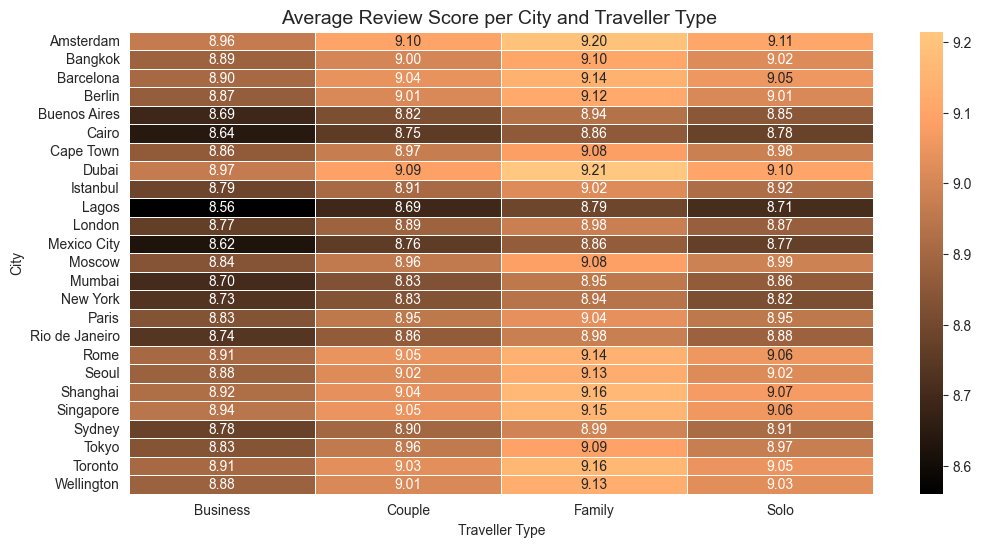

In [217]:
pivot = pd.pivot_table(
        df_merged,
        index="hotel_city",
        columns="user_traveller_type",
        values="review_score_overall",
        aggfunc="mean"
    )

plt.figure(figsize = (12,6))


sns.heatmap(pivot, annot=True, cmap="copper", fmt=".2f", linewidths=0.5)

# Extra GUI enhancements
plt.title("Average Review Score per City and Traveller Type ", fontsize=14)
plt.xlabel("Traveller Type")
plt.ylabel("City")
plt.show()


### Insights from the Heatmap

Using the heatmap visualization, we can observe clear differences in average review scores across traveller types and cities:

- **Business travellers:** Dubai achieved the highest average score of **8.97**.
- **Couples:** Amsterdam recorded the highest average score of **9.10**.
- **Families:** Dubai again stood out with an average score of **9.21**.
- **Solo travellers:** Amsterdam had the highest average score of **9.11**.


## 2 - Top 3 Countries by Value-for-Money per Age Group

### Build a Heatmap of correlations for Hotels' Countries, Age Groups and the Average Value for Money

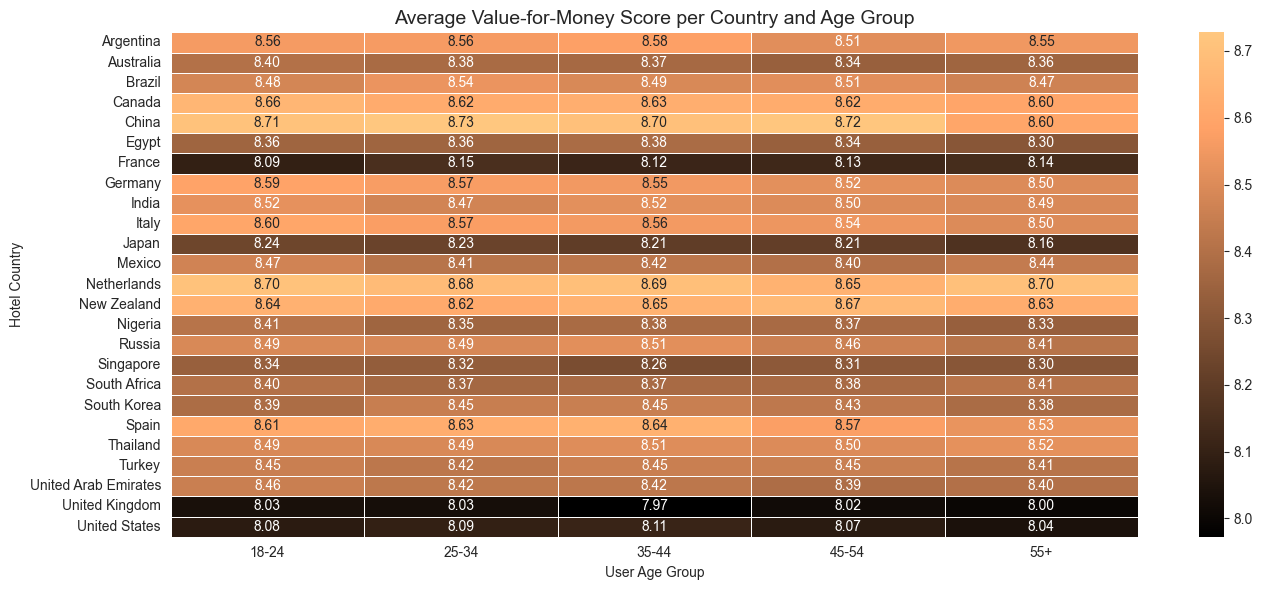

In [226]:
pivot = pd.pivot_table(
    df_merged,
    index="hotel_country",
    columns="user_age_group",
    values="review_score_value_for_money",
    aggfunc="mean"
)

plt.figure(figsize=(14, 6))

sns.heatmap(
    pivot,
    annot=True,
    cmap="copper",
    fmt=".2f",
    linewidths=0.5
)

# Extra GUI Interface
plt.title("Average Value-for-Money Score per Country and Age Group", fontsize=14)
plt.xlabel("User Age Group")
plt.ylabel("Hotel Country")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Insights per Age Group (Value-for-Money)

- **18–24:** China (8.71), Netherlands (8.70), Canada (8.66)
- **25–34:** China (8.73), Netherlands (8.68), Spain (8.63)
- **35–44:** China (8.70), Netherlands (8.69), New Zealand (8.65)
- **45–54:** China (8.72), New Zealand (8.67), Netherlands (8.65)
- **55+:** Netherlands (8.70), New Zealand (8.63), China (8.60)
